In [2]:
import pickle
import pandas as pd
import os
import json

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

In [3]:
def cleanedData():

    print("Getting cleaned data")

    directory = './podatki'
    data = []
    max_zaporedna_stevilka = 0  

    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            try:
                frame = pd.read_csv(
                    filepath,
                    delimiter=';',
                    encoding='utf-8',
                )
                frame['ZaporednaStevilkaPN'] += max_zaporedna_stevilka
                max_zaporedna_stevilka = frame['ZaporednaStevilkaPN'].max()  

                data.append(frame)
            except Exception as e:
                print(f"Napaka pri branju {filename}: {str(e)}")
                continue

    combined_data = pd.concat(data, ignore_index=True)
    return combined_data

Pridobi vse različne podatke nekega stolpca

In [4]:
def printAllValues(data, colum):
    print(colum + ": ", data[colum].unique())

Odstani neuporabne parametre za model

In [5]:
def removeUnusedColumns(data):
    print("Removing unused columns")

    data = data.drop(columns=["DatumPN", "ZaporednaStevilkaOsebeVPN", "VozniskiStazVMesecih", "ZaporednaStevilkaPN"])
    return data

Odstrani vse vrstice, pri katerih nekateri stolpci nimajo vrednosti

In [6]:
def removeNaNValues(data):
    print("Removing Nan values")
    return data.dropna()

Pretvorba ure prometne nesreče iz zvezne v diskretno spremenljivko. Primer: 23.15 -> 23

In [7]:
def discretsizeUraPN(data):
    print("Discreticising UraPN")
    data["UraPN"] = (data["UraPN"] // 1).astype(int)
    return data

Odstrani vrstice brez koordinat

In [8]:
def removeUnknownGeoKoordinata(data):
    print("Removing unknown GEOKooridnate")
    data = data[(data["GeoKoordinataX"] != 0) & (data["GeoKoordinataY"] != 0)]
    return data

Pretvorba zveznih koordinat v diskretne. Po pretvorbi lahko gledamo na podatke kot neko mrežo. Primer: 51263 -> 5

In [9]:
def descretisizeGeoKoordinata(data):
    print("Discreticising GEOKoordinate")
    data["GeoKoordinataX"] = data["GeoKoordinataX"] // 10000
    data["GeoKoordinataY"] = data["GeoKoordinataY"] // 10000
    return data

Odstrani vse vrstice, pri katerih starost ni znana

In [10]:
def removeUnknownStarost(data):
    print("Removing unknown starost")
    data = data[data["Starost"] != -1]
    return data

Pretvorba starosti iz "zvezne" spremenljivko v diskretno. Primer: 23 -> 2 (pomen: udeleženec star 20-30 let)

In [11]:
def discretsizeStarost(data):
    print("Discreticising starost")
    data["Starost"] = (data["Starost"] // 10).astype(int)
    return data

Pretvorba Vozniškega staza v letih iz "zvezne" spremenljivko v diskretno. Primer: 23 -> 2 (pomen: udeležencev vozniški staz 20-30 let)

In [12]:
def discretsizeVoznikStazVLetih(data):
    print("Discreticising Vozniški staz v letih")
    data["VozniskiStazVLetih"] = (data["VozniskiStazVLetih"] // 10).astype(int)
    return data

Pretvorba vrednost alkotesta iz zvezne v diskrteno spremenljivko. Primer 0.12 -> 1 (pomen: vrednost alkotesta 0.1-0.2). Ob napovedi potrebno deliti napoved z 10

In [13]:
def discretsizeVrednostAlkotesta(data):
    print("Discreticising vrednost alkotesta")
    data["VrednostAlkotesta"] = data["VrednostAlkotesta"].str.replace(",", ".").astype(float)
    data["VrednostAlkotesta"] = data["VrednostAlkotesta"].round(1) * 10
    data["VrednostAlkotesta"] = data["VrednostAlkotesta"].astype(int)
    return data

Pretvorba vrednost strokovnega pregleda iz zvezne v diskrteno spremenljivko. Primer 1.12 -> 11 (pomen: vrednost pregleda 1.1-1.2). Ob napovedi potrebno deliti napoved z 10

In [14]:
def discretsizeVrednostStrokovnegaPregleda(data):
    print("Discreticising vrednost strokovnega pregleda")
    data["VrednostStrokovnegaPregleda"] = data["VrednostStrokovnegaPregleda"].str.replace(",", ".").astype(float)
    data["VrednostStrokovnegaPregleda"] = data["VrednostStrokovnegaPregleda"].round(1) * 10
    data["VrednostStrokovnegaPregleda"] = data["VrednostStrokovnegaPregleda"].astype(float)
    return data

In [15]:
def process_column(args):
        
        dataToPredictionPath = "data_To_Prediction/"
        predictionToDataPath = "prediction_To_Data/"

        column, colData = args
        print("Saving and replacing string values with ints in: " + column)

        strToInt = dict()
        intToStr = dict()

        distinctColumnData = colData.unique().tolist()
        for intVal, strVal in enumerate(distinctColumnData):
            strToInt[strVal] = intVal
            intToStr[intVal] = strVal

        with open(dataToPredictionPath + column + ".json", "w") as f1:
            json.dump(strToInt, f1, indent=4)

        with open(predictionToDataPath + column + ".json", "w") as f2:
            json.dump(intToStr, f2, indent=4)


        updated_col = colData.replace(strToInt)

        return column, updated_col

In [16]:
def replaceStringData(data):
    textData = [col for col in data.columns if pd.api.types.is_string_dtype(data[col])]

    args = [(col, data[col]) for col in textData]

    with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = executor.map(process_column, args)

    for column, updatedCol in results:
        data[column] = updatedCol.astype(int)

    return data

Preprocesiranje podatkov

In [17]:
def preprocessData():
    cleanData = cleanedData()
    selectedColumns = removeUnusedColumns(cleanData)
    selectedColumns = removeNaNValues(selectedColumns)
    selectedColumns = discretsizeUraPN(selectedColumns)
    selectedColumns = removeUnknownGeoKoordinata(selectedColumns)
    selectedColumns = descretisizeGeoKoordinata(selectedColumns)
    selectedColumns = removeUnknownStarost(selectedColumns)
    selectedColumns = discretsizeStarost(selectedColumns)
    selectedColumns = discretsizeVoznikStazVLetih(selectedColumns)
    selectedColumns = discretsizeVrednostAlkotesta(selectedColumns)
    selectedColumns = discretsizeVrednostStrokovnegaPregleda(selectedColumns)
    selectedColumns = replaceStringData(selectedColumns)
    return selectedColumns


In [ ]:
def generateModelsRandomForest(data):
    modelPath = "models_Random_Forest/"
    
    #for label in data.columns:
    for label in ["SifraCesteNaselja"]:
        modelFile = open(modelPath + label + "_model.pkl", "wb")
        accuracyList = open(modelPath + "accuracy.txt", "a")

        print("Generating model: " + label)

        targetVariable = data[label]
        learningData = data.drop(columns=[label])

        trainData, testData, trainTarget, testTarget = train_test_split(learningData, targetVariable, test_size=0.2)
        model = model = RandomForestClassifier(
            n_estimators=200,       
            max_depth=20,           
            min_samples_split=5,    
            min_samples_leaf=2,     
            max_features='sqrt',    
            n_jobs=-1,              
            random_state=42      
        )
        model.fit(trainData, trainTarget)
        pickle.dump(model, modelFile)
        predictions = model.predict(testData)
        accuracyList.write("predicting: " + label + " " + str(accuracy_score(testTarget, predictions)) + "\n")
        modelFile.close()
        accuracyList.close()

Generiranje modelov z naivinim bayasom

In [24]:
def generateModelsNaiveBayas(data):
    modelPath = "models_naiveBayas/"
    
    for label in data.columns:
        modelFile = open(modelPath + label + "_model.pkl", "wb")
        accuracyList = open(modelPath + "accuracy.txt", "a")

        print("Generating model: " + label)

        targetVariable = data[label]
        learningData = data.drop(columns=[label])

        trainData, testData, trainTarget, testTarget = train_test_split(learningData, targetVariable, test_size=0.2)
        model = MultinomialNB()
        model.fit(trainData, trainTarget)
        pickle.dump(model, modelFile)
        predictions = model.predict(testData)
        accuracyList.write("predicting: " + label + " " + str(accuracy_score(testTarget, predictions)) + "\n")
        modelFile.close()
        accuracyList.close()

In [20]:
def generateAccuracyGraph(path):
    f = open(path, "r").readlines()
    modelName = []
    accuracy = []
    for line in f:
        _, name, acc = line.split()
        modelName.append(name)
        accuracy.append((float(acc) * 100  // 0.1 / 10))
    
    graphData = pd.DataFrame(
        {
            "name" : modelName,
            "accuracy" : accuracy
        }
    )
    graphData = graphData.sort_values(by="accuracy", ascending=False)
    plt.figure(figsize=(20,10))
    plt.bar(graphData["name"], graphData["accuracy"])
    plt.title("Točnosti posameznih modelov generiranih z naivnim bayesom")
    plt.ylabel("Točnost modela v %")
    plt.xlabel("Ime modela")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 100)
    plt.axis("tight")
    y_ticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f"{int(val)}%" if val.is_integer() else f"{val:.1f}%" for val in y_ticks])
    plt.tight_layout()
    plt.savefig("accuracy_graph.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    


In [21]:
data = preprocessData()

Getting cleaned data
Removing unused columns
Removing Nan values
Discreticising UraPN
Removing unknown GEOKooridnate
Discreticising GEOKoordinate
Removing unknown starost
Discreticising starost
Discreticising Vozniški staz v letih
Discreticising vrednost alkotesta
Discreticising vrednost strokovnega pregleda
Saving and replacing string values with ints in: KlasifikacijaNesrece
Saving and replacing string values with ints in: UpravnaEnotaStoritve
Saving and replacing string values with ints in: VNaselju
Saving and replacing string values with ints in: Lokacija
Saving and replacing string values with ints in: VrstaCesteNaselja
Saving and replacing string values with ints in: SifraCesteNaselja
Saving and replacing string values with ints in: TekstCesteNaselja
Saving and replacing string values with ints in: TekstOdsekaUlice
Saving and replacing string values with ints in: OpisKraja
Saving and replacing string values with ints in: VzrokNesrece
Saving and replacing string values with ints i

In [22]:
#generateModelsNaiveBayas(data)


In [23]:
generateModelsRandomForest(data)

Generating model: KlasifikacijaNesrece
Generating model: UpravnaEnotaStoritve


KeyboardInterrupt: 

/tmp/ipykernel_9788/4158165676.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{int(val)}%" if val.is_integer() else f"{val:.1f}%" for val in y_ticks])


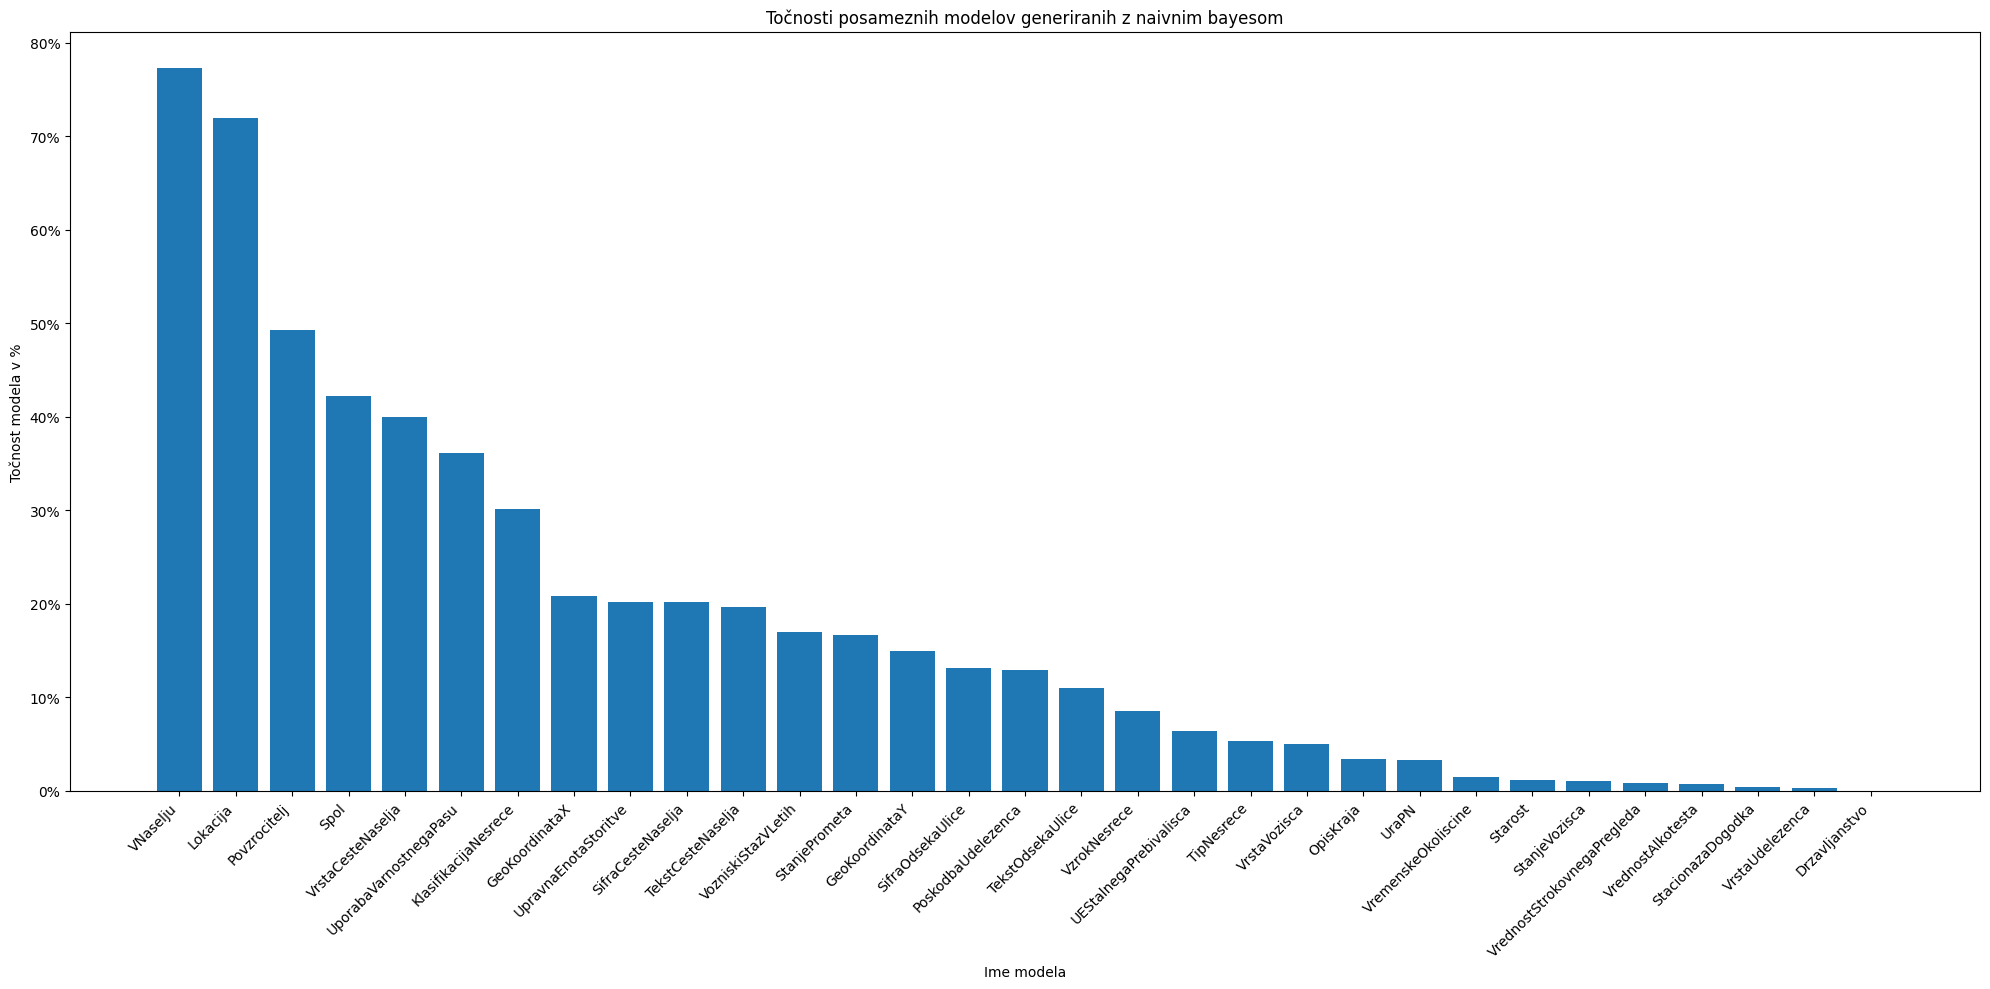

In [ ]:
path = ""
generateAccuracyGraph(path)